# 中央値の信頼区間

In [1]:
using Distributions
using StatsPlots
default(titlefontsize=12, fmt=:png)
using Random
using StatsBase

name(dist::UnivariateDistribution) = replace(string(dist), r"{[^{.]*}"=>"")

name (generic function with 1 method)

## 中央値の信頼区間はの計算はこれだけでよい

(L, U) = (2.8217972816098222, 6.290915833587727)


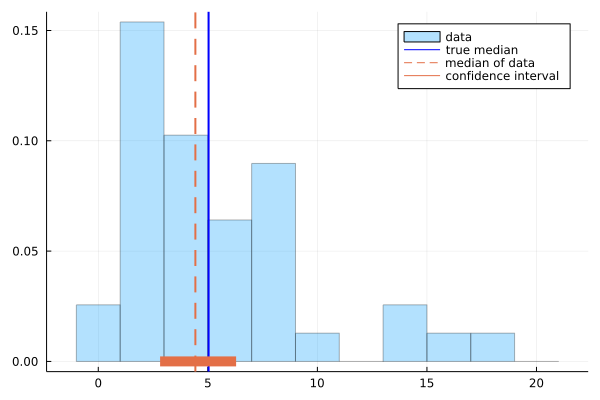

In [2]:
# テストサンプルの生成
dist = Gamma(2, 3)
n = 40
X = rand(dist, n)

# 標本Xの経験分布Xdistを作成
c = countmap(X)
u = collect(keys(c))
w = values(c) ./ n
Xdist = DiscreteNonParametric(u, w)

# Xdistとベータ分布のquantileで信頼区間を計算
beta = Beta((n+1)/2, (n+1)/2)
L = quantile(Xdist, quantile(beta, 0.025))
U = quantile(Xdist, quantile(beta, 0.975))
@show L, U

# プロット
histogram(X; norm=true, alpha=0.3, bin=-1:2:21, label="data")
vline!([median(dist)]; label="true median", lw=2, c=:blue)
vline!([median(X)]; label="median of data", lw=2, c=2, ls=:dash)
plot!([L, U], zeros(2); label="confidence interval", lw=10, c=2)

(L, U) = (2.9390894291394893, 6.346185370042445)


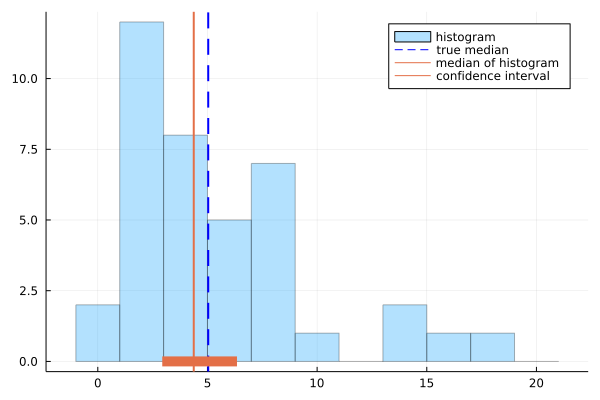

In [3]:
# ヒストグラムデータを作成
h = fit(Histogram, X, -1:2:21)

# ヒストグラムから得られる分布hdistを作成
e = h.edges[1]
w = h.weights
c = [Uniform(e[i], e[i+1]) for i in eachindex(e)[1:end-1]]
p = w / sum(w)
hdist = MixtureModel(c, p)

# hdistとベータ分布を用いて信頼区間を計算
beta = Beta((n+1)/2, (n+1)/2)
L = quantile(hdist, quantile(beta, 0.025))
U = quantile(hdist, quantile(beta, 0.975))
@show L, U

# プロット
plot(h; norm=true, alpha=0.3, label="histogram")
vline!([median(dist)]; label="true median", ls=:dash, lw=2, c=:blue)
vline!([median(hdist)]; label="median of histogram", lw=2, c=2)
plot!([L, U], zeros(2); label="confidence interval", lw=10, c=2)

## もっと一般的な実装

### 順序統計量の分布のcdfとquantile

In [4]:
"""分布distのサイズnの標本の下からk番目の値の分布のcdf"""
cdf_ordstat(dist, n, k, x) = cdf(Beta(k, n-k+1), cdf(dist, x))

"""分布distの標本中央値の分布のcdf"""
cdf_median(dist, n, x) = cdf_ordstat(dist, n, (n+1)/2, x)

"""分布distのサイズnの標本の下からk番目の値の分布のquantle(cdfの逆函数)"""
quantile_ordstat(dist, n, k, p) = quantile(dist, quantile(Beta(k, n-k+1), p))

"""分布distの標本中央値の分布のquantle(cdfの逆函数)"""
quantile_median(dist, n, p) = quantile_ordstat(dist, n, (n+1)/2, p)

quantile_median

### 標本の経験分布やヒストグラムの分布

In [5]:
"""標本Xの経験分布(標本に重複がないことを仮定)"""
function empiricaldist(X)
    n = length(X)
    DiscreteNonParametric(X, fill(1/n, n))
end

"""標本Xの経験分布(標本に重複があってもよい)"""
function empiricaldist_allowrep(X) # very slow
    c = countmap(X)
    u = collect(keys(c))
    w = values(c) ./ length(X)
    DiscreteNonParametric(u, w) 
end

"""ヒストグラムの分布"""
function histogramdist(h::Histogram)
    e = h.edges[1]
    w = h.weights
    c = [Uniform(e[i], e[i+1]) for i in eachindex(e)[1:end-1]]
    p = w/sum(w)
    MixtureModel(c, p)
end

histogramdist

h = fit(Histogram, X, -4.25:0.5:4.25) = Histogram{Int64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}
edges:
  -4.25:0.5:4.25
weights: [0, 1, 0, 2, 7, 15, 26, 41, 39, 35, 16, 14, 2, 2, 0, 0, 0]
closed: left
isdensity: false
hdist = histogramdist(h) = MixtureModel{Uniform{Float64}}(K = 17)
components[1] (prior = 0.0000): Uniform{Float64}(a=-4.25, b=-3.75)
components[2] (prior = 0.0050): Uniform{Float64}(a=-3.75, b=-3.25)
components[3] (prior = 0.0000): Uniform{Float64}(a=-3.25, b=-2.75)
components[4] (prior = 0.0100): Uniform{Float64}(a=-2.75, b=-2.25)
components[5] (prior = 0.0350): Uniform{Float64}(a=-2.25, b=-1.75)
components[6] (prior = 0.0750): Uniform{Float64}(a=-1.75, b=-1.25)
components[7] (prior = 0.1300): Uniform{Float64}(a=-1.25, b=-0.75)
components[8] (prior = 0.2050): Uniform{Float64}(a=-0.75, b=-0.25)
The rest are omitted ...



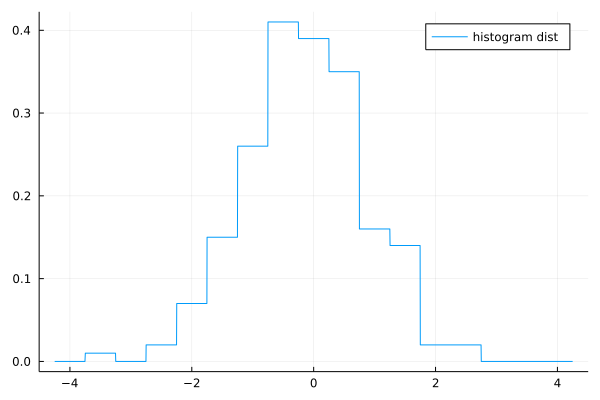

In [6]:
dist = Normal()
n = 200
X = rand(dist, n)
@show h = fit(Histogram, X, -4.25:0.5:4.25)
@show hdist = histogramdist(h)
plot(x -> pdf(hdist, x), extrema(hdist)...; label="histogram dist")

### P値函数と信頼区間

In [7]:
prevx(x::AbstractFloat) = prevfloat(x)
prevx(x::Integer) = x - 1

"""分布の順序統計量のP値"""
pval_ordstat(dist, n, k, a) = min(
    1,
    2cdf_ordstat(dist, n, k, a),
    2(1 - cdf_ordstat(dist, n, k, prevx(a)))
)

"""標本の順序統計量のP値"""
function pval_ordstat(X::AbstractVector, n, k, a; empiricaldist_func = empiricaldist_allowrep)
    dist = empiricaldist_func(X)
    pval_ordstat(dist, n, k, a)
end
pval_ordstat(X::AbstractVector, k, a; empiricaldist_func = empiricaldist_allowrep) =
    pval_ordstat(X, length(X), k, a; empiricaldist_func)

"""ヒストグラムの順序統計量のP値"""
function pval_ordstat(h::Histogram, n, k, a)
    dist = histogramdist(h)
    pval_ordstat(dist, n, k, a)
end

"""分布の標本中央値のP値"""
pval_median(dist, n, a) = pval_ordstat(dist, n, (n+1)/2, a)

"""標本の分布の標本(bootstrap)の中央値のP値"""
pval_median(X::AbstractVector, n, a; empiricaldist_func = empiricaldist_allowrep) =
    pval_ordstat(X, n, (n+1)/2, a; empiricaldist_func)
pval_median(X::AbstractVector, a; empiricaldist_func = empiricaldist_allowrep) =
    pval_median(X, length(X), a; empiricaldist_func)

"""ヒストグラムの分布の標本の中央値のP値"""
pval_median(h::Histogram, n, a) = pval_ordstat(h, n, (n+1)/2, a)

pval_median

In [8]:
"""分布の順序統計量の信頼区間"""
function ci_ordstat(dist, n, k; α = 0.05)
    L = quantile_ordstat(dist, n, k, α/2)
    U = quantile_ordstat(dist, n, k, 1 - α/2)
    L, U
end

"""標本の分布の順序統計量の信頼区間"""
ci_ordstat(X::AbstractVector, n, k; α = 0.05) = ci_ordstat(empiricaldist_allowrep(X), n, k; α)
ci_ordstat(X::AbstractVector, k; α = 0.05) = ci_ordstat(X, length(X), k; α)

"""ヒストグラムの分布の順序統計量の信頼区間"""
ci_ordstat(h::Histogram, n, k; α = 0.05) = ci_ordstat(histogramdist(h), n, k; α)

"""分布の中央値の信頼区間"""
ci_median(dist, n, k; α = 0.05) = ci_ordstat(dist, n, (n+1)/2; α)

"""標本の分布の中央値の信頼区間"""
ci_median(X::AbstractVector, n; α = 0.05) = ci_ordstat(X, n, (n+1)/2; α)
ci_median(X::AbstractVector; α = 0.05) = ci_median(X, length(X); α)

"""ヒストグラムの分布の中央値の信頼区間"""
ci_median(h::Histogram, n; α = 0.05) = ci_ordstat(h, n, (n+1)/2; α)

ci_median

## 計算例

### RのDescToolsによる中央値の信頼区間の計算との比較

https://stats.stackexchange.com/questions/502977/confidence-interval-for-median-which-is-more-appropriate-bootstrap-or-binom-ex

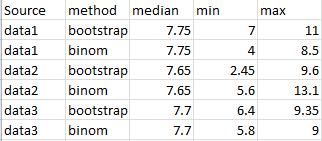

以下の計算結果はこの表のmethodがbinomの場合とぴったり一致している.

In [9]:
X = data1 = [8,    7,  8,  9.5,    1,  20, 8,  7.5,    3,  20.5,   2.5,    5.5,    15.5,   2,  4,  1,
    17,   2,  3.5,    8.5,    8.5,    2.5,    11, 4,  10.5,   7.5,    12, 5,  16.5,   8.5]
ci_median(X)

(4.0, 8.5)

In [10]:
X = data2 = [7.1,  32.0,   3.8,    1.6,    19.6,   6.0,    7.2,    14.9,   0,  2.0,    5.7,
          19.4, 13.1,   15.5,   11.3,   9.6,    13.9,   5.6,    12.6,   1.0,    1.9,
          8.1,  15.9,   0.8,    6.1,    8.1,    18.0,   4.6,    5.5,    15.6]
ci_median(X)

(5.6, 13.1)

In [11]:
X = data3 = [16.1, 10.4,   0.5,    12.2,   7.2,    1.7,    21.6,   6.3,    0.8,    3.2,    12.6,   20.0,   3.4, 7.3,   3.5,
          7.5,  15.8, 4.7, 8.3, 11.9,   1.6,    9.0, 8.6,   11.7,   8.1, 5.8, 3.3,  7.9,    7.0,    8.5]
ci_median(X)

(5.8, 9.0)

### P値函数と信頼区間

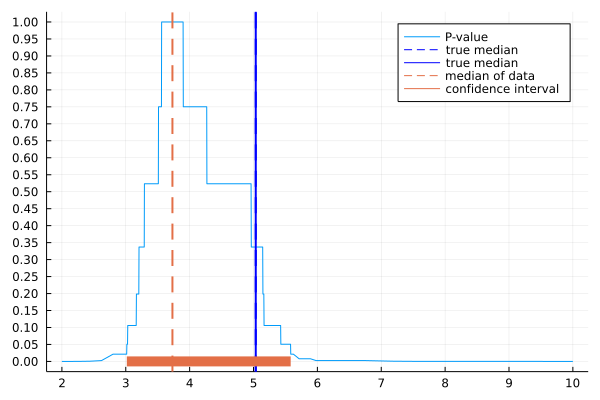

In [12]:
dist = Gamma(2, 3)
n = 40
X = rand(dist, n)
L, U = ci_median(X)

plot(x -> pval_median(X, x; empiricaldist_func = empiricaldist), 2, 10; label="P-value")
vline!([median(dist)]; label="true median", ls=:dash, lw=2, c=:blue)
vline!([median(dist)]; label="true median", lw=2, c=:blue)
vline!([median(X)]; label="median of data", lw=2, c=2, ls=:dash)
plot!([L, U], zeros(2); label="confidence interval", lw=10, c=2)
plot!(; xtick=0:20, ytick=0:0.05:1)

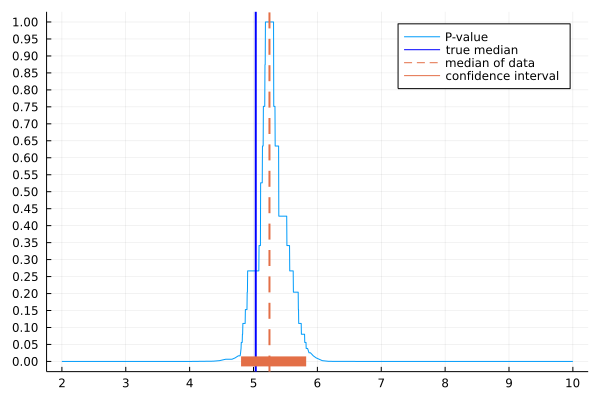

In [13]:
dist = Gamma(2, 3)
n = 160
X = rand(dist, n)
L, U = ci_median(X)

plot(x -> pval_median(X, x; empiricaldist_func = empiricaldist), 2, 10; label="P-value")
vline!([median(dist)]; label="true median", lw=2, c=:blue)
vline!([median(X)]; label="median of data", lw=2, c=2, ls=:dash)
plot!([L, U], zeros(2); label="confidence interval", lw=10, c=2)
plot!(; xtick=0:20, ytick=0:0.05:1)

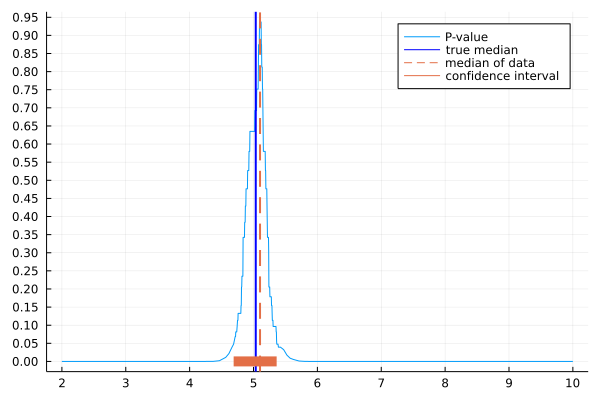

In [14]:
dist = Gamma(2, 3)
n = 640
X = rand(dist, n)
L, U = ci_median(X)

plot(x -> pval_median(X, x; empiricaldist_func = empiricaldist), 2, 10; label="P-value")
vline!([median(dist)]; label="true median", lw=2, c=:blue)
vline!([median(X)]; label="median of data", lw=2, c=2, ls=:dash)
plot!([L, U], zeros(2); label="confidence interval", lw=10, c=2)
plot!(; xtick=0:20, ytick=0:0.05:1)

### 第一種の過誤の確率

第一種の過誤の確率は母集団分布によらない.

In [15]:
function sim_mediantest(; n = 40, dists = [Normal(2, 3), Gamma(2, 3), Exponential(2), LogNormal()], L = 10^5)
    a = median.(dists)
    pval = Matrix{Float64}(undef, L, length(dists))
    tmp = [Vector{Float64}(undef, n) for _ in 1:Threads.nthreads()]
    Threads.@threads for i in 1:L
        for (j, dist) in enumerate(dists)
            X = rand!(dist, tmp[Threads.threadid()])
            pval[i, j] = pval_median(X, a[j]; empiricaldist_func = empiricaldist)
        end
    end
    pval
end

function plot_mediantest(; n = 40, dists = [Normal(2, 3), Gamma(2, 3), Exponential(2), LogNormal()], L = 10^5)
    pval = sim_mediantest(; n, dists, L)
    PP = []
    for (j, dist) in enumerate(dists)
        m = median(dist)
        s = std(dist)/√n
        P = plot(; legend=false)
        plot!(a -> ecdf(@view pval[:, j])(a), 0, 0.1; label="")
        plot!([0, 0.1], [0, 0.1]; label="", c=:black, ls=:dot)
        plot!(; xtick=0:0.01:1, ytick=0:0.01:1, xrotation=90)
        title!("$(name(dist)), n=$n")
        push!(PP, P)
    end
    plot(PP...; size=(640, 600), layout=(2, 2), titlefontsize=10, tickfontsize=6)
end

plot_mediantest (generic function with 1 method)

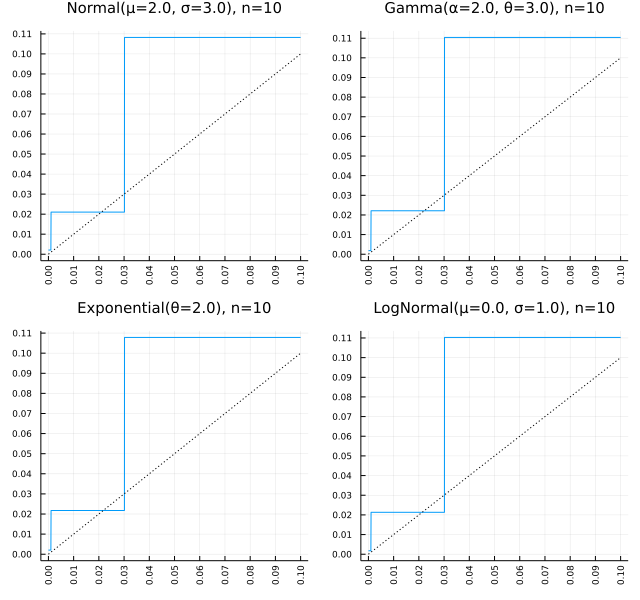

In [16]:
plot_mediantest(; n = 10)

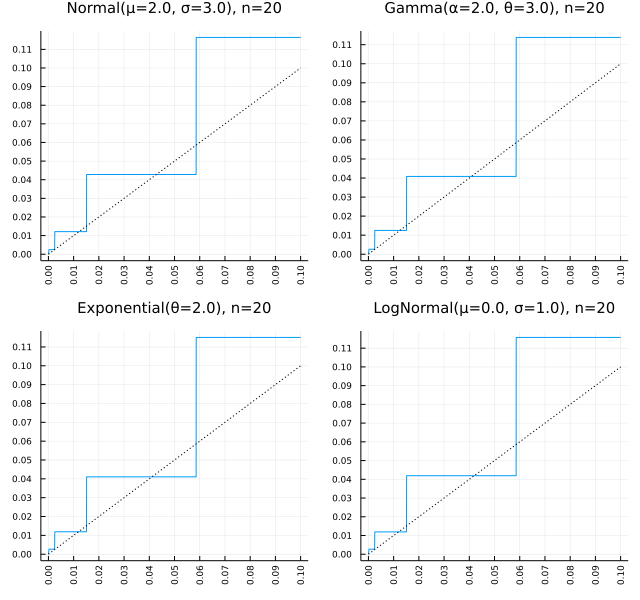

In [17]:
plot_mediantest(; n = 20)

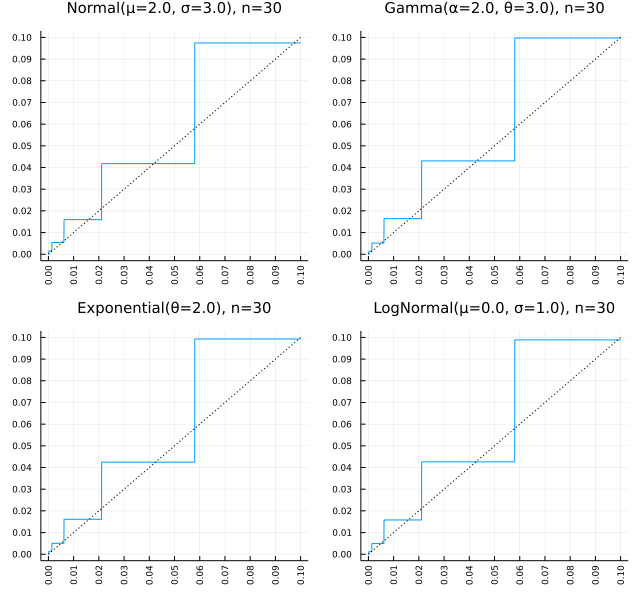

In [18]:
plot_mediantest(; n = 30)

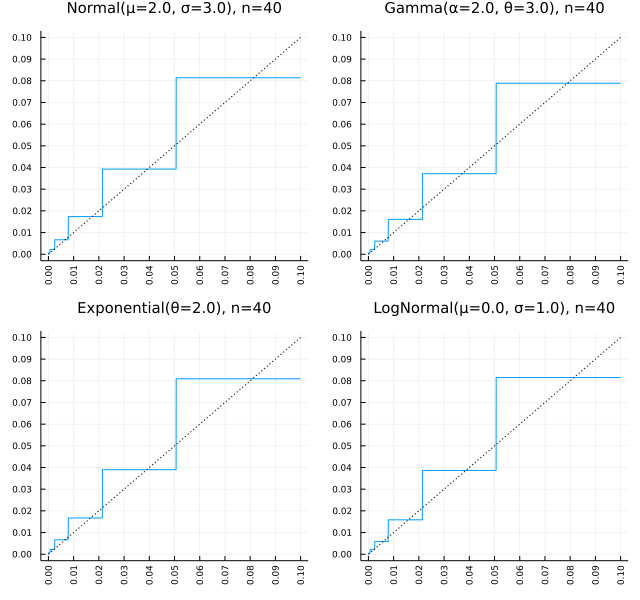

In [19]:
plot_mediantest(; n = 40)

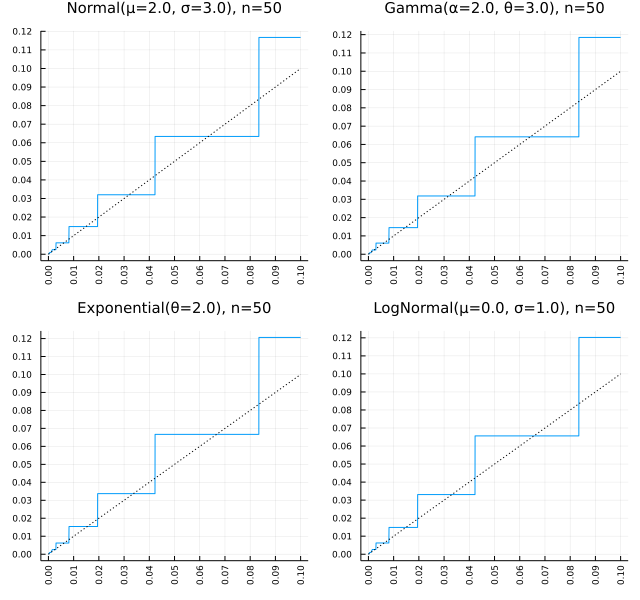

In [20]:
plot_mediantest(; n = 50)

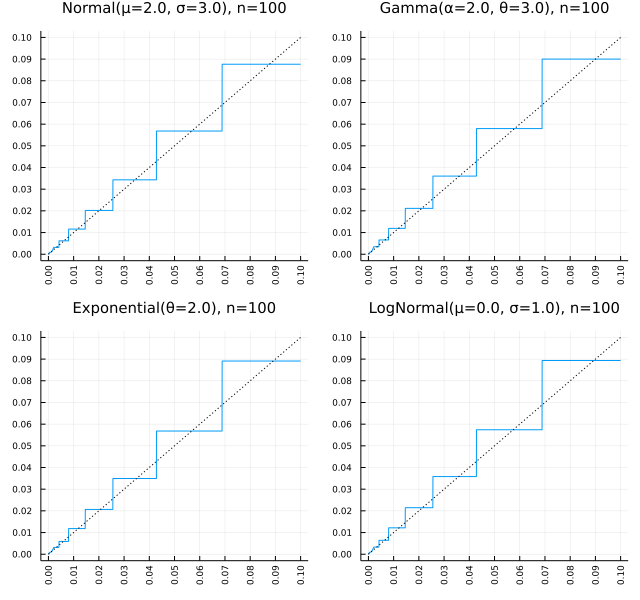

In [21]:
plot_mediantest(; n = 100)

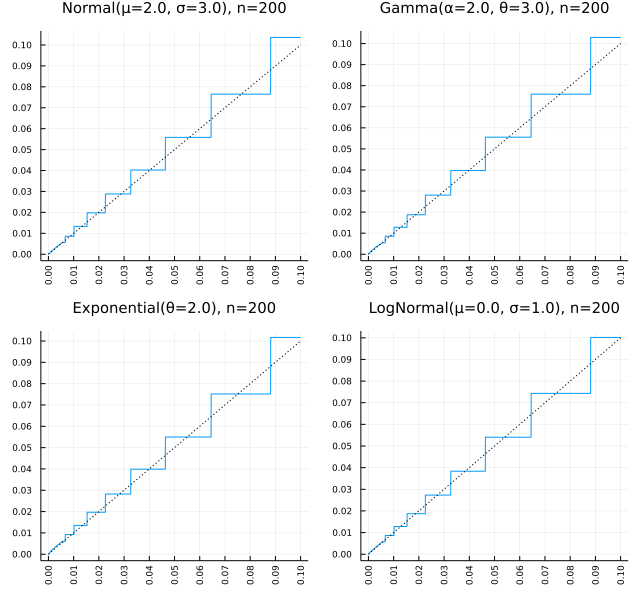

In [22]:
plot_mediantest(; n = 200)

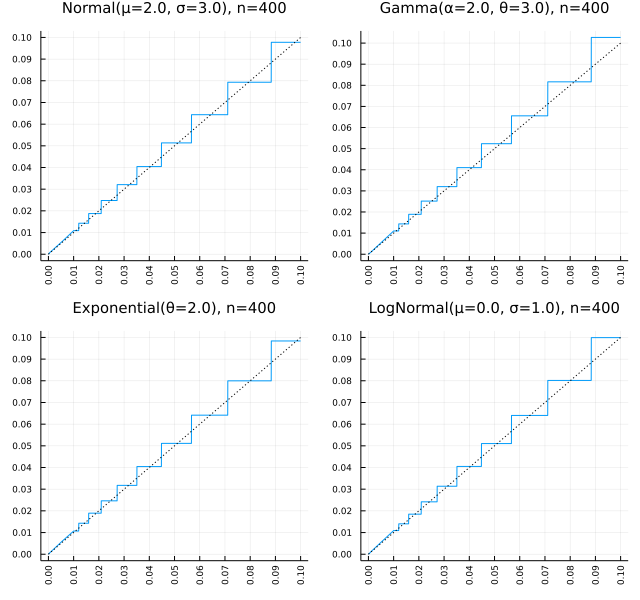

In [23]:
plot_mediantest(; n = 400)